# Complete GCN Max-Cut Training Pipeline

This notebook demonstrates the complete pipeline for training a Graph Convolutional Network on 3-way max-cut problems:

1. **Graph Generation**: Create 200-400 random graphs with 500 nodes and degree 6-8
2. **Data Processing**: Use GraphCreator and graphExtender to create training dataset
3. **Model Training**: Train 3-way max-cut neural network using TrainingNeural.py
4. **Model Persistence**: Save the trained model for future use

## Dataset Specifications
- **Number of graphs**: 300 (between 200-400 as requested)
- **Nodes per graph**: 500
- **Average degree**: 6-8 (random within range)
- **Problem type**: 3-way max-cut with terminal constraints

In [1]:
# Import required modules
import sys
import os
import numpy as np
import networkx as nx
import torch
from pathlib import Path
from time import time
import random

from RandomAlgorithm.RandomizedMaxCut import (
    create_random_regular_graph,
    calculate_cut_value,
    randomized_k_way_maxcut,
    evaluate_algorithm_on_graphs,
    benchmark_algorithm,
    analyze_results,
    test_fixed_terminals,
    quick_demo
)

# Add the current directory to Python path for imports
current_dir = Path.cwd()
if str(current_dir) not in sys.path:
    sys.path.append(str(current_dir))

# Import our custom modules
from DataGenerator.GraphCreator import generate_graph_dataset, save_graphs_to_pickle, save_terminals_to_pickle, generate_graph, generate_unique_terminals
from DataGenerator.graphExtender import process_graphs_from_folder
from Training.TrainingNeural import TrainingConfig, train_from_pickle, save_neural_model
from commons import save_object, open_file

print("All modules imported successfully!")
print(f"Current working directory: {current_dir}")
print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")

All modules imported successfully!
Current working directory: /Users/javaad/Documents/research/GCN-max-cut/python
PyTorch version: 2.7.1
CUDA available: False


## Step 1: Graph Generation

Generate 300 random graphs with specified parameters using GraphCreator.

In [2]:
# Configuration for graph generation
DATASET_CONFIG = {
    'num_graphs': 20,
    'num_nodes': 500,
    'min_degree': 6,
    'max_degree': 8,
    'num_terminals': 3,  # For 3-way max-cut
    'output_directory': './training_data',
    'dataset_name': 'maxcut_3way_n500_d6_8_t300'
}

# Create output directory
os.makedirs(DATASET_CONFIG['output_directory'], exist_ok=True)

print("Dataset Configuration:")
for key, value in DATASET_CONFIG.items():
    print(f"  {key}: {value}")

Dataset Configuration:
  num_graphs: 20
  num_nodes: 500
  min_degree: 6
  max_degree: 8
  num_terminals: 3
  output_directory: ./training_data
  dataset_name: maxcut_3way_n500_d6_8_t300


In [3]:
# Generate graphs using the available functions
print("Generating graphs...")
start_time = time()

all_graphs = {}
all_terminals = {}

for i in range(DATASET_CONFIG['num_graphs']):
    # Random degree within specified range
    avg_degree = random.randint(DATASET_CONFIG['min_degree'], DATASET_CONFIG['max_degree'])

    # Generate graph using available function
    graph = generate_graph(
        n=DATASET_CONFIG['num_nodes'],
        d=avg_degree,
        graph_type='reg',  # Regular graph
        random_seed=i + 1000,  # Ensure reproducibility with unique seeds
        edge_weight=1,
        edge_capacity=1
    )

    # Generate unique terminal nodes
    terminals = generate_unique_terminals(
        DATASET_CONFIG['num_nodes'],
        DATASET_CONFIG['num_terminals']
    )

    # Store with consistent naming
    graph_name = f"graph_{i:04d}_n{DATASET_CONFIG['num_nodes']}_d{avg_degree}"
    all_graphs[graph_name] = graph
    all_terminals[graph_name] = terminals

    # Progress update every 50 graphs
    if (i + 1) % 50 == 0:
        elapsed = time() - start_time
        avg_time = elapsed / (i + 1)
        eta = avg_time * (DATASET_CONFIG['num_graphs'] - i - 1)
        print(f"  Generated {i + 1}/{DATASET_CONFIG['num_graphs']} graphs. "
              f"Elapsed: {elapsed:.1f}s, ETA: {eta:.1f}s")

generation_time = time() - start_time
print(f"\nGraph generation completed in {generation_time:.2f} seconds")
print(f"Generated {len(all_graphs)} graphs with {len(all_terminals)} terminal sets")

Generating graphs...

Graph generation completed in 0.18 seconds
Generated 20 graphs with 20 terminal sets


In [4]:
# Analyze generated dataset
print("\nDataset Analysis:")
node_counts = [len(graph.nodes()) for graph in all_graphs.values()]
edge_counts = [len(graph.edges()) for graph in all_graphs.values()]
degrees = [sum(dict(graph.degree()).values()) / len(graph.nodes()) for graph in all_graphs.values()]

print(f"Nodes per graph: {min(node_counts)} - {max(node_counts)} (target: {DATASET_CONFIG['num_nodes']})")
print(f"Edges per graph: {min(edge_counts)} - {max(edge_counts)}")
print(f"Average degree: {min(degrees):.2f} - {max(degrees):.2f} (target: {DATASET_CONFIG['min_degree']}-{DATASET_CONFIG['max_degree']})")
print(f"Mean average degree: {np.mean(degrees):.2f}")

# Check terminal sets
terminal_lens = [len(terminals) for terminals in all_terminals.values()]
print(f"Terminals per graph: {min(terminal_lens)} - {max(terminal_lens)} (target: {DATASET_CONFIG['num_terminals']})")

# Sample a few graphs for verification
print("\nSample graphs:")
for i, (name, graph) in enumerate(list(all_graphs.items())[:3]):
    terminals = all_terminals[name]
    avg_deg = sum(dict(graph.degree()).values()) / len(graph.nodes())
    print(f"  {name}: {len(graph.nodes())} nodes, {len(graph.edges())} edges, "
          f"avg_degree={avg_deg:.2f}, terminals={terminals}")


Dataset Analysis:
Nodes per graph: 500 - 500 (target: 500)
Edges per graph: 1500 - 2000
Average degree: 6.00 - 8.00 (target: 6-8)
Mean average degree: 7.10
Terminals per graph: 3 - 3 (target: 3)

Sample graphs:
  graph_0000_n500_d7: 500 nodes, 1750 edges, avg_degree=7.00, terminals=[33, 175, 326]
  graph_0001_n500_d7: 500 nodes, 1750 edges, avg_degree=7.00, terminals=[244, 373, 303]
  graph_0002_n500_d8: 500 nodes, 2000 edges, avg_degree=8.00, terminals=[144, 129, 406]


## Step 2: Save Generated Graphs

Save the generated graphs and terminals to pickle files for persistence.

In [5]:
# Save raw graphs and terminals
graphs_file = os.path.join(DATASET_CONFIG['output_directory'], f"{DATASET_CONFIG['dataset_name']}_graphs.pkl")
terminals_file = os.path.join(DATASET_CONFIG['output_directory'], f"{DATASET_CONFIG['dataset_name']}_terminals.pkl")

print("Saving generated data...")
save_graphs_to_pickle(all_graphs, graphs_file)
save_terminals_to_pickle(all_terminals, terminals_file)

print(f"Graphs saved to: {graphs_file}")
print(f"Terminals saved to: {terminals_file}")

# Verify files were created
print(f"\nFile verification:")
print(f"  Graphs file size: {os.path.getsize(graphs_file) / 1024 / 1024:.2f} MB")
print(f"  Terminals file size: {os.path.getsize(terminals_file) / 1024 / 1024:.2f} MB")

Saving generated data...
Graphs saved to: ./training_data/maxcut_3way_n500_d6_8_t300_graphs.pkl
Terminals saved to: ./training_data/maxcut_3way_n500_d6_8_t300_terminals.pkl

File verification:
  Graphs file size: 1.06 MB
  Terminals file size: 0.00 MB


## Step 3: Process Graphs for Training

Use graphExtender to convert raw graphs into training-ready format with DGL graphs and adjacency matrices.

In [6]:
# Configuration for graph processing
MAX_NODES = 1000  # Extended matrix size for training
BATCH_SIZE = 100  # Process in batches to manage memory

print("Processing graphs for training...")
start_time = time()

# Process graphs using graphExtender
processed_dataset = process_graphs_from_folder(
    all_graphs=all_graphs,
    all_terminals=all_terminals,
    max_nodes=MAX_NODES,
    save_batch_size=BATCH_SIZE,
    output_filename_prefix=f"{DATASET_CONFIG['dataset_name']}_processed"
)

processing_time = time() - start_time
print(f"Graph processing completed in {processing_time:.2f} seconds")
print(f"Processed {len(processed_dataset)} graphs for training")

Processing graphs for training...
Terminal swapped 0
Graph finished: 1
Terminal swapped 1
Graph finished: 2
Terminal swapped 2
Graph finished: 3
Terminal swapped 3
Graph finished: 4
Terminal swapped 4
Graph finished: 5
Terminal swapped 5
Graph finished: 6
Terminal swapped 6
Graph finished: 7
Terminal swapped 7
Graph finished: 8
Terminal swapped 8
Graph finished: 9
Terminal swapped 9
Graph finished: 10
Terminal swapped 10
Graph finished: 11
Terminal swapped 11
Graph finished: 12
Terminal swapped 12
Graph finished: 13
Terminal swapped 13
Graph finished: 14
Terminal swapped 14
Graph finished: 15
Terminal swapped 15
Graph finished: 16
Terminal swapped 16
Graph finished: 17
Terminal swapped 17
Graph finished: 18
Terminal swapped 18
Graph finished: 19
Terminal swapped 19
Graph finished: 20
Skipped items: 0
Graph processing completed in 12.86 seconds
Processed 20 graphs for training


In [7]:
# Analyze processed dataset
print("\nProcessed Dataset Analysis:")
sample_key = list(processed_dataset.keys())[0]
dgl_graph, adjacency_matrix, nx_graph, terminals = processed_dataset[sample_key]

print(f"Number of processed graphs: {len(processed_dataset)}")
print(f"Sample data structure:")
print(f"  DGL graph nodes: {dgl_graph.number_of_nodes()}")
print(f"  DGL graph edges: {dgl_graph.number_of_edges()}")
print(f"  Adjacency matrix shape: {adjacency_matrix.shape}")
print(f"  Adjacency matrix device: {adjacency_matrix.device}")
print(f"  Adjacency matrix dtype: {adjacency_matrix.dtype}")
print(f"  NetworkX graph: {type(nx_graph)} with {len(nx_graph.nodes())} nodes")
print(f"  Terminals: {terminals}")

# Check terminal normalization (should be [0, 1, 2] after processing)
terminal_sets = [data[3] for data in processed_dataset.values()]
unique_terminals = set(tuple(sorted(t)) for t in terminal_sets)
print(f"\nTerminal normalization check:")
print(f"  Unique terminal sets: {unique_terminals}")
print(f"  Expected: {(0, 1, 2)}")


Processed Dataset Analysis:
Number of processed graphs: 20
Sample data structure:
  DGL graph nodes: 500
  DGL graph edges: 3500
  Adjacency matrix shape: torch.Size([500, 1000])
  Adjacency matrix device: cpu
  Adjacency matrix dtype: torch.float32
  NetworkX graph: <class 'networkx.classes.graph.Graph'> with 500 nodes
  Terminals: [0, 1, 2]

Terminal normalization check:
  Unique terminal sets: {(0, 1, 2)}
  Expected: (0, 1, 2)


In [8]:
# Save processed dataset
processed_file = os.path.join(DATASET_CONFIG['output_directory'], f"{DATASET_CONFIG['dataset_name']}_training_ready.pkl")

print("Saving processed dataset...")
save_object(processed_dataset, processed_file)

print(f"Processed dataset saved to: {processed_file}")
print(f"File size: {os.path.getsize(processed_file) / 1024 / 1024:.2f} MB")

# Verify we can reload the data
print("\nVerifying saved dataset...")
reloaded_dataset = open_file(processed_file)
print(f"Successfully reloaded {len(reloaded_dataset)} graphs from disk")

Saving processed dataset...
Processed dataset saved to: ./training_data/maxcut_3way_n500_d6_8_t300_training_ready.pkl
File size: 40.31 MB

Verifying saved dataset...
Successfully reloaded 20 graphs from disk


## Step 4: Configure Neural Network Training

Set up training configuration for the 3-way max-cut GCN model.

In [9]:
# Training configuration
training_config = TrainingConfig(
    # Model architecture
    n_nodes=MAX_NODES,  # Maximum nodes (extended matrix size)
    dim_embedding=MAX_NODES,  # Embedding dimension
    hidden_dim=MAX_NODES // 2,  # Hidden layer dimension
    dropout=0.0,  # No dropout for now
    number_classes=3,  # 3-way max-cut
    
    # Training parameters
    learning_rate=0.001,  # Standard learning rate
    number_epochs=1000,  # Maximum epochs
    tolerance=1e-4,  # Early stopping tolerance
    patience=20,  # Early stopping patience
    
    # Loss parameters
    A=0.0,  # Penalty parameter A
    C=1.0,  # Penalty parameter C
    penalty=1000.0,  # Terminal independence penalty
    
    # Saving parameters
    save_directory=f"{DATASET_CONFIG['dataset_name']}_model.pth",
    save_frequency=100  # Save checkpoint every 100 epochs
)

print("Training Configuration:")
print(f"  Model: {training_config.n_nodes} nodes, {training_config.number_classes} classes")
print(f"  Architecture: {training_config.dim_embedding} -> {training_config.hidden_dim} -> {training_config.number_classes}")
print(f"  Training: {training_config.number_epochs} epochs, lr={training_config.learning_rate}")
print(f"  Early stopping: patience={training_config.patience}, tolerance={training_config.tolerance}")
print(f"  Loss: A={training_config.A}, C={training_config.C}, penalty={training_config.penalty}")
print(f"  Model save path: {training_config.save_directory}")

Training Configuration:
  Model: 1000 nodes, 3 classes
  Architecture: 1000 -> 500 -> 3
  Training: 1000 epochs, lr=0.001
  Early stopping: patience=20, tolerance=0.0001
  Loss: A=0.0, C=1.0, penalty=1000.0
  Model save path: maxcut_3way_n500_d6_8_t300_model.pth


## Step 5: Train the Neural Network

Train the GCN model on the processed dataset using the consolidated TrainingNeural module.

In [10]:
# Train the model
print("Starting neural network training...")
print(f"Dataset: {len(processed_dataset)} graphs")
print(f"Device: {'CUDA' if torch.cuda.is_available() else 'CPU'}")
print("=" * 60)

training_start_time = time()

# Train using the processed dataset directly
trained_model, best_loss, final_epoch, embedding_weights, loss_history = train_from_pickle(
    dataset_filename=processed_file,
    model_name=DATASET_CONFIG['dataset_name'],
    n_nodes=training_config.n_nodes,
    dim_embedding=training_config.dim_embedding,
    hidden_dim=training_config.hidden_dim,
    dropout=training_config.dropout,
    number_classes=training_config.number_classes,
    learning_rate=training_config.learning_rate,
    number_epochs=training_config.number_epochs,
    tolerance=training_config.tolerance,
    patience=training_config.patience,
    A=training_config.A,
    C=training_config.C,
    penalty=training_config.penalty,
    save_frequency=training_config.save_frequency
)

training_time = time() - training_start_time

print("=" * 60)
print(f"Training completed in {training_time:.2f} seconds ({training_time/60:.1f} minutes)")
print(f"Best loss achieved: {best_loss:.6f}")
print(f"Final epoch: {final_epoch}")
print(f"Total training epochs: {len(loss_history)}")

Starting neural network training...
Dataset: 20 graphs
Device: CPU
Loading dataset from ./training_data/maxcut_3way_n500_d6_8_t300_training_ready.pkl
Starting training with 1000 epochs
Model: 1000 nodes, 3 classes
Device: cpu
Epoch: 0, Cumulative Loss: -13388.000023
Epoch: 100, Cumulative Loss: -30915.000000
Epoch: 200, Cumulative Loss: -31193.000000
Epoch: 300, Cumulative Loss: -31270.000000
Epoch: 400, Cumulative Loss: -31338.000000
Early stopping at epoch 485
Training completed in 171.21 seconds
Best loss: -31355.000000
Final model saved to ./final_maxcut_3way_n500_d6_8_t300.pth
Training completed in 171.81 seconds (2.9 minutes)
Best loss achieved: -31355.000000
Final epoch: 485
Total training epochs: 486


## Step 6: Analyze Training Results

Examine the training progress and model performance.

Training Analysis:
  Initial loss: -13388.000023
  Final loss: -31355.000000
  Best loss: -31355.000000
  Loss improvement: 17966.999977
  Convergence: Early stopping


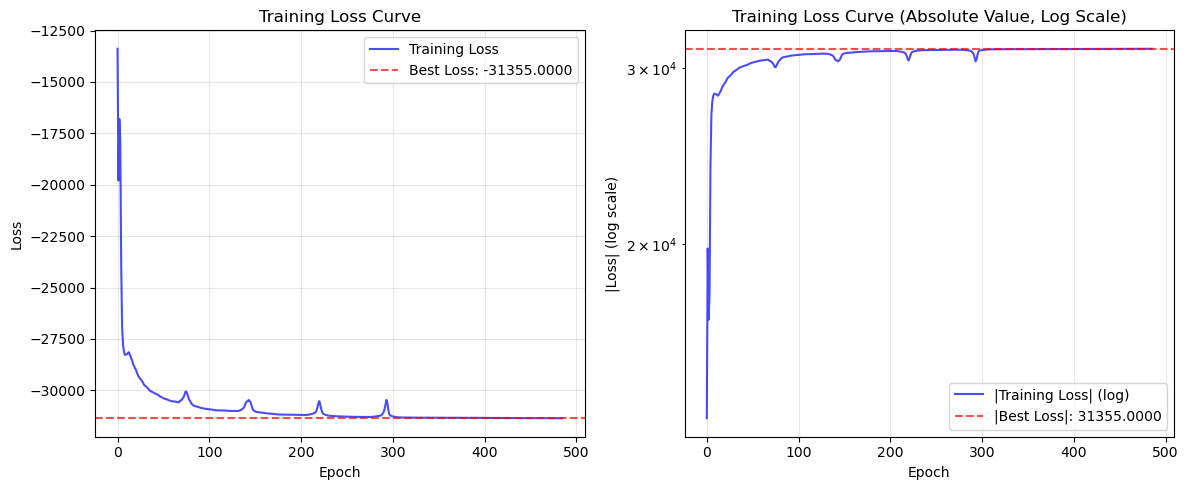


Training Statistics:
  Average time per epoch: 0.35 seconds
  Model parameters: 502,003
  Embedding shape: torch.Size([1000, 1000])


In [11]:
    # Analyze training results
import matplotlib.pyplot as plt

print("Training Analysis:")
print(f"  Initial loss: {loss_history[0]:.6f}")
print(f"  Final loss: {loss_history[-1]:.6f}")
print(f"  Best loss: {best_loss:.6f}")
print(f"  Loss improvement: {loss_history[0] - best_loss:.6f}")
print(f"  Convergence: {'Early stopping' if final_epoch < training_config.number_epochs - 1 else 'Full epochs'}")

# Plot training curve
plt.figure(figsize=(12, 5))

# Loss curve
plt.subplot(1, 2, 1)
plt.plot(loss_history, 'b-', alpha=0.7, label='Training Loss')
plt.axhline(y=best_loss, color='r', linestyle='--', alpha=0.7, label=f'Best Loss: {best_loss:.4f}')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss Curve')
plt.legend()
plt.grid(True, alpha=0.3)

# Loss curve (absolute value log scale for negative losses)
plt.subplot(1, 2, 2)
# Take absolute value of negative losses for log scale plotting
abs_loss_history = [abs(loss) for loss in loss_history]
abs_best_loss = abs(best_loss)
plt.semilogy(abs_loss_history, 'b-', alpha=0.7, label='|Training Loss| (log)')
plt.axhline(y=abs_best_loss, color='r', linestyle='--', alpha=0.7, label=f'|Best Loss|: {abs_best_loss:.4f}')
plt.xlabel('Epoch')
plt.ylabel('|Loss| (log scale)')
plt.title('Training Loss Curve (Absolute Value, Log Scale)')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Training statistics
print(f"\nTraining Statistics:")
print(f"  Average time per epoch: {training_time / len(loss_history):.2f} seconds")
print(f"  Model parameters: {sum(p.numel() for p in trained_model.parameters()):,}")
print(f"  Embedding shape: {embedding_weights.shape}")

## Step 7: Save and Document the Complete Pipeline

Save all artifacts and create comprehensive documentation.

In [12]:
# Create comprehensive results package
results_package = {
    'dataset_config': DATASET_CONFIG,
    'training_config': training_config,
    'training_results': {
        'best_loss': best_loss,
        'final_epoch': final_epoch,
        'loss_history': loss_history,
        'training_time': training_time,
        'generation_time': generation_time,
        'processing_time': processing_time
    },
    'dataset_stats': {
        'num_graphs': len(all_graphs),
        'avg_nodes': np.mean([len(g.nodes()) for g in all_graphs.values()]),
        'avg_edges': np.mean([len(g.edges()) for g in all_graphs.values()]),
        'avg_degree': np.mean([sum(dict(g.degree()).values()) / len(g.nodes()) for g in all_graphs.values()])
    },
    'file_paths': {
        'raw_graphs': graphs_file,
        'raw_terminals': terminals_file,
        'processed_dataset': processed_file,
        'trained_model': f"./final_{training_config.save_directory}"
    }
}

# Save results package
results_file = os.path.join(DATASET_CONFIG['output_directory'], f"{DATASET_CONFIG['dataset_name']}_complete_results.pkl")
save_object(results_package, results_file)

print("Complete Results Package Saved:")
print(f"  File: {results_file}")
print(f"  Size: {os.path.getsize(results_file) / 1024 / 1024:.2f} MB")

Complete Results Package Saved:
  File: ./training_data/maxcut_3way_n500_d6_8_t300_complete_results.pkl
  Size: 0.01 MB


In [13]:
from datetime import datetime
# Create detailed summary report
summary_report = f"""
# GCN Max-Cut Training Pipeline - Complete Summary

## Experiment Overview
- **Date**: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}
- **Dataset**: {DATASET_CONFIG['dataset_name']}
- **Objective**: 3-way max-cut problem with GCN

## Dataset Generation
- **Graphs generated**: {DATASET_CONFIG['num_graphs']}
- **Nodes per graph**: {DATASET_CONFIG['num_nodes']}
- **Target degree range**: {DATASET_CONFIG['min_degree']}-{DATASET_CONFIG['max_degree']}
- **Actual average degree**: {results_package['dataset_stats']['avg_degree']:.2f}
- **Generation time**: {generation_time:.2f} seconds

## Data Processing
- **Extended matrix size**: {MAX_NODES} x {MAX_NODES}
- **Processing time**: {processing_time:.2f} seconds
- **Terminal normalization**: All graphs normalized to terminals [0, 1, 2]

## Model Training
- **Architecture**: GCN with {training_config.dim_embedding} -> {training_config.hidden_dim} -> {training_config.number_classes}
- **Training time**: {training_time:.2f} seconds ({training_time/60:.1f} minutes)
- **Epochs completed**: {len(loss_history)}/{training_config.number_epochs}
- **Best loss**: {best_loss:.6f}
- **Convergence**: {'Early stopping' if final_epoch < training_config.number_epochs - 1 else 'Full epochs'}

## File Artifacts
- **Raw graphs**: {graphs_file}
- **Raw terminals**: {terminals_file}
- **Training dataset**: {processed_file}
- **Trained model**: ./final_{training_config.save_directory}
- **Complete results**: {results_file}

## Usage Instructions

### Load the trained model:
```python
from Training.TrainingNeural import load_neural_model, TrainingConfig
config = TrainingConfig(n_nodes={training_config.n_nodes}, number_classes={training_config.number_classes})
model, inputs, config = load_neural_model('./final_{training_config.save_directory}', config)
```

### Load the training dataset:
```python
from commons import open_file
dataset = open_file('{processed_file}')
```

### Load complete results:
```python
results = open_file('{results_file}')
```

## Total Pipeline Time
- **Graph generation**: {generation_time:.1f}s
- **Data processing**: {processing_time:.1f}s  
- **Model training**: {training_time:.1f}s
- **Total time**: {generation_time + processing_time + training_time:.1f}s ({(generation_time + processing_time + training_time)/60:.1f} minutes)
"""

# Save summary report
summary_file = os.path.join(DATASET_CONFIG['output_directory'], f"{DATASET_CONFIG['dataset_name']}_SUMMARY.md")
with open(summary_file, 'w') as f:
    f.write(summary_report)

print(summary_report)
print(f"\nSummary report saved to: {summary_file}")


# GCN Max-Cut Training Pipeline - Complete Summary

## Experiment Overview
- **Date**: 2025-08-19 20:46:23
- **Dataset**: maxcut_3way_n500_d6_8_t300
- **Objective**: 3-way max-cut problem with GCN

## Dataset Generation
- **Graphs generated**: 20
- **Nodes per graph**: 500
- **Target degree range**: 6-8
- **Actual average degree**: 7.10
- **Generation time**: 0.18 seconds

## Data Processing
- **Extended matrix size**: 1000 x 1000
- **Processing time**: 12.86 seconds
- **Terminal normalization**: All graphs normalized to terminals [0, 1, 2]

## Model Training
- **Architecture**: GCN with 1000 -> 500 -> 3
- **Training time**: 171.81 seconds (2.9 minutes)
- **Epochs completed**: 486/1000
- **Best loss**: -31355.000000
- **Convergence**: Early stopping

## File Artifacts
- **Raw graphs**: ./training_data/maxcut_3way_n500_d6_8_t300_graphs.pkl
- **Raw terminals**: ./training_data/maxcut_3way_n500_d6_8_t300_terminals.pkl
- **Training dataset**: ./training_data/maxcut_3way_n500_d6_8_t300_tra

## Step 8: Verification and Testing

Test the saved model to ensure it works correctly.

In [14]:
# Test model loading and inference
from Training.TrainingNeural import load_neural_model, evaluate_model

print("Testing saved model...")

# Load the saved model
model_path = f"./final_{training_config.save_directory}"
test_config = TrainingConfig(
    n_nodes=training_config.n_nodes,
    number_classes=training_config.number_classes,
    dim_embedding=training_config.dim_embedding,
    hidden_dim=training_config.hidden_dim
)

try:
    loaded_model, loaded_inputs, loaded_config = load_neural_model(model_path, test_config)
    print("✓ Model loaded successfully")
    
    # Test on a small subset of the dataset
    test_subset = {k: v for k, v in list(processed_dataset.items())[:5]}
    eval_results = evaluate_model(loaded_model, test_subset, test_config)
    
    print("✓ Model evaluation successful")
    print(f"  Test loss: {eval_results['average_loss']:.6f}")
    print(f"  Test samples: {eval_results['num_samples']}")
    
except Exception as e:
    print(f"✗ Model testing failed: {e}")

print("\n" + "="*60)
print("PIPELINE COMPLETED SUCCESSFULLY!")
print("="*60)
print(f"Dataset: {DATASET_CONFIG['num_graphs']} graphs with {DATASET_CONFIG['num_nodes']} nodes each")
print(f"Model: 3-way max-cut GCN with best loss {best_loss:.6f}")
print(f"All artifacts saved in: {DATASET_CONFIG['output_directory']}")

Testing saved model...
✓ Model loaded successfully
✓ Model evaluation successful
  Test loss: -1241.800000
  Test samples: 5

PIPELINE COMPLETED SUCCESSFULLY!
Dataset: 20 graphs with 500 nodes each
Model: 3-way max-cut GCN with best loss -31355.000000
All artifacts saved in: ./training_data


## Step 9: Create Testing Set

Generate a separate testing dataset to validate our trained model:
- 5 graphs with 500 nodes each  
- Apply graph extender for consistency with training format

In [15]:
# Configuration for testing dataset  
TEST_CONFIG = {
    'num_graphs': 5,
    'num_nodes': 500,
    'min_degree': 6,
    'max_degree': 8,
    'num_terminals': 3,  # For 3-way max-cut
    'output_directory': './testing_data',
    'dataset_name': 'maxcut_3way_test_n500_d6_8_t5'
}

# Create output directory
os.makedirs(TEST_CONFIG['output_directory'], exist_ok=True)

print("Testing Dataset Configuration:")
for key, value in TEST_CONFIG.items():
    print(f"  {key}: {value}")

# Generate testing graphs
print("\nGenerating testing graphs...")
test_start_time = time()

test_graphs = {}
test_terminals = {}

for i in range(TEST_CONFIG['num_graphs']):
    # Random degree within specified range
    avg_degree = random.randint(TEST_CONFIG['min_degree'], TEST_CONFIG['max_degree'])

    # Generate graph using available function with different seeds to ensure uniqueness
    graph = generate_graph(
        n=TEST_CONFIG['num_nodes'],
        d=avg_degree,
        graph_type='reg',  # Regular graph
        random_seed=i + 5000,  # Different seed range to avoid overlap with training set
        edge_weight=1,
        edge_capacity=1
    )

    # Generate unique terminal nodes
    terminals = generate_unique_terminals(
        TEST_CONFIG['num_nodes'],
        TEST_CONFIG['num_terminals']
    )

    # Store with consistent naming
    graph_name = f"test_graph_{i:04d}_n{TEST_CONFIG['num_nodes']}_d{avg_degree}"
    test_graphs[graph_name] = graph
    test_terminals[graph_name] = terminals

test_generation_time = time() - test_start_time
print(f"Testing graph generation completed in {test_generation_time:.2f} seconds")
print(f"Generated {len(test_graphs)} test graphs with {len(test_terminals)} terminal sets")

Testing Dataset Configuration:
  num_graphs: 5
  num_nodes: 500
  min_degree: 6
  max_degree: 8
  num_terminals: 3
  output_directory: ./testing_data
  dataset_name: maxcut_3way_test_n500_d6_8_t5

Generating testing graphs...
Testing graph generation completed in 0.03 seconds
Generated 5 test graphs with 5 terminal sets


In [16]:
# Save testing graphs and terminals
test_graphs_file = os.path.join(TEST_CONFIG['output_directory'], f"{TEST_CONFIG['dataset_name']}_graphs.pkl")
test_terminals_file = os.path.join(TEST_CONFIG['output_directory'], f"{TEST_CONFIG['dataset_name']}_terminals.pkl")

print("Saving testing data...")
save_graphs_to_pickle(test_graphs, test_graphs_file)
save_terminals_to_pickle(test_terminals, test_terminals_file)

print(f"Test graphs saved to: {test_graphs_file}")
print(f"Test terminals saved to: {test_terminals_file}")

# Verify files were created
print(f"\nFile verification:")
print(f"  Test graphs file size: {os.path.getsize(test_graphs_file) / 1024 / 1024:.2f} MB")
print(f"  Test terminals file size: {os.path.getsize(test_terminals_file) / 1024 / 1024:.2f} MB")

Saving testing data...
Test graphs saved to: ./testing_data/maxcut_3way_test_n500_d6_8_t5_graphs.pkl
Test terminals saved to: ./testing_data/maxcut_3way_test_n500_d6_8_t5_terminals.pkl

File verification:
  Test graphs file size: 0.25 MB
  Test terminals file size: 0.00 MB


In [17]:
# Process testing graphs for evaluation
print("Processing testing graphs...")
test_processing_start_time = time()

# Process test graphs using graphExtender
processed_test_dataset = process_graphs_from_folder(
    all_graphs=test_graphs,
    all_terminals=test_terminals,
    max_nodes=MAX_NODES,
    save_batch_size=None,  # Don't save in batches for small test set
    output_filename_prefix=f"{TEST_CONFIG['dataset_name']}_processed"
)

test_processing_time = time() - test_processing_start_time
print(f"Test graph processing completed in {test_processing_time:.2f} seconds")
print(f"Processed {len(processed_test_dataset)} test graphs for evaluation")

# Save processed test dataset
test_processed_file = os.path.join(TEST_CONFIG['output_directory'], f"{TEST_CONFIG['dataset_name']}_testing_ready.pkl")
print(f"Saving processed test dataset to: {test_processed_file}")
save_object(processed_test_dataset, test_processed_file)

Processing testing graphs...
Terminal swapped 0
Graph finished: 1
Terminal swapped 1
Graph finished: 2
Terminal swapped 2
Graph finished: 3
Terminal swapped 3
Graph finished: 4
Terminal swapped 4
Graph finished: 5
Skipped items: 0
Test graph processing completed in 3.32 seconds
Processed 5 test graphs for evaluation
Saving processed test dataset to: ./testing_data/maxcut_3way_test_n500_d6_8_t5_testing_ready.pkl


## Step 10: Algorithm Comparison

Compare the performance of the trained GCN model against the randomized algorithm on a single test graph.

In [18]:
# Analyze processed testing dataset
print("\nProcessed Testing Dataset Analysis:")
test_sample_key = list(processed_test_dataset.keys())[0]
test_dgl_graph, test_adjacency_matrix, test_nx_graph, test_terminals_processed = processed_test_dataset[test_sample_key]

print(f"Number of processed test graphs: {len(processed_test_dataset)}")
print(f"Sample test data structure:")
print(f"  DGL graph nodes: {test_dgl_graph.number_of_nodes()}")
print(f"  DGL graph edges: {test_dgl_graph.number_of_edges()}")
print(f"  Adjacency matrix shape: {test_adjacency_matrix.shape}")
print(f"  Adjacency matrix device: {test_adjacency_matrix.device}")
print(f"  Adjacency matrix dtype: {test_adjacency_matrix.dtype}")
print(f"  NetworkX graph: {type(test_nx_graph)} with {len(test_nx_graph.nodes())} nodes")
print(f"  Terminals: {test_terminals_processed}")

# Check terminal normalization for test set
test_terminal_sets = [data[3] for data in processed_test_dataset.values()]
test_unique_terminals = set(tuple(sorted(t)) for t in test_terminal_sets)
print(f"\nTest set terminal normalization check:")
print(f"  Unique terminal sets: {test_unique_terminals}")
print(f"  Expected: {(0, 1, 2)}")

# Verify consistency with training set format
print(f"\nConsistency check with training set:")
print(f"  Training adjacency matrix shape: {adjacency_matrix.shape}")
print(f"  Testing adjacency matrix shape: {test_adjacency_matrix.shape}")
print(f"  Format consistency: {'✓' if adjacency_matrix.shape == test_adjacency_matrix.shape else '✗'}")


Processed Testing Dataset Analysis:
Number of processed test graphs: 5
Sample test data structure:
  DGL graph nodes: 500
  DGL graph edges: 3000
  Adjacency matrix shape: torch.Size([500, 1000])
  Adjacency matrix device: cpu
  Adjacency matrix dtype: torch.float32
  NetworkX graph: <class 'networkx.classes.graph.Graph'> with 500 nodes
  Terminals: [0, 1, 2]

Test set terminal normalization check:
  Unique terminal sets: {(0, 1, 2)}
  Expected: (0, 1, 2)

Consistency check with training set:
  Training adjacency matrix shape: torch.Size([500, 1000])
  Testing adjacency matrix shape: torch.Size([500, 1000])
  Format consistency: ✓


In [19]:
# Get one graph object from the processed test dataset for comparison
test_graph_key = list(processed_test_dataset.keys())[0]
dgl_graph, adjacency_matrix, nx_graph, terminals = processed_test_dataset[test_graph_key]

print(f"Selected graph: {test_graph_key}")
print(f"Graph properties:")
print(f"  Nodes: {len(nx_graph.nodes())}")
print(f"  Edges: {len(nx_graph.edges())}")
print(f"  Terminals: {terminals}")
print(f"  DGL graph nodes: {dgl_graph.number_of_nodes()}")
print(f"  DGL graph edges: {dgl_graph.number_of_edges()}")
print(f"  Adjacency matrix shape: {adjacency_matrix.shape}")

# Create terminal constraints for the randomized algorithm
# The terminals are normalized to [0, 1, 2], we need to map them to actual node IDs
terminal_constraints = {terminals[0]: 0, terminals[1]: 1, terminals[2]: 2}

print(f"Terminal constraints: {terminal_constraints}")

Selected graph: 0
Graph properties:
  Nodes: 500
  Edges: 1500
  Terminals: [0, 1, 2]
  DGL graph nodes: 500
  DGL graph edges: 3000
  Adjacency matrix shape: torch.Size([500, 1000])
Terminal constraints: {0: 0, 1: 1, 2: 2}


In [20]:
# Get one graph object from the extender (processed test dataset)
test_graph_key = list(processed_test_dataset.keys())[0]
dgl_graph, adjacency_matrix, nx_graph, terminals = processed_test_dataset[test_graph_key]

print(f"Selected graph: {test_graph_key}")
print(f"Graph properties:")
print(f"  Nodes: {len(nx_graph.nodes())}")
print(f"  Edges: {len(nx_graph.edges())}")
print(f"  Terminals: {terminals}")
print(f"  DGL graph nodes: {dgl_graph.number_of_nodes()}")
print(f"  DGL graph edges: {dgl_graph.number_of_edges()}")
print(f"  Adjacency matrix shape: {adjacency_matrix.shape}")

Selected graph: 0
Graph properties:
  Nodes: 500
  Edges: 1500
  Terminals: [0, 1, 2]
  DGL graph nodes: 500
  DGL graph edges: 3000
  Adjacency matrix shape: torch.Size([500, 1000])


In [22]:
# Run the graph through the randomized algorithm
print("=" * 50)
print("RANDOMIZED ALGORITHM EVALUATION")
print("=" * 50)

print(f"Terminal constraints: {terminal_constraints}")

# Run randomized algorithm
randomized_start_time = time()
randomized_cut_value, randomized_partition = randomized_k_way_maxcut(
    nx_graph,
    k=3,
    max_iterations=1000,
    threshold=0,
    patience=50,
    fixed_terminals=terminal_constraints,
    random_seed=42
)
randomized_time = time() - randomized_start_time

print(f"Randomized Algorithm Results:")
print(f"  Cut value: {randomized_cut_value}")
print(f"  Runtime: {randomized_time:.4f} seconds")

# Calculate partition distribution manually instead of using pandas
partition_counts = {}
for partition in randomized_partition.values():
    partition_counts[partition] = partition_counts.get(partition, 0) + 1
print(f"  Partition distribution: {dict(sorted(partition_counts.items()))}")

# Verify terminal constraints were satisfied
print(f"Terminal constraint verification:")
for terminal_node, expected_partition in terminal_constraints.items():
    actual_partition = randomized_partition[terminal_node]
    print(f"  Node {terminal_node} -> Partition {actual_partition} (expected {expected_partition}): {'✓' if actual_partition == expected_partition else '✗'}")

RANDOMIZED ALGORITHM EVALUATION
Terminal constraints: {0: 0, 1: 1, 2: 2}
Randomized Algorithm Results:
  Cut value: 1046
  Runtime: 0.0681 seconds
  Partition distribution: {0: 176, 1: 164, 2: 160}
Terminal constraint verification:
  Node 0 -> Partition 0 (expected 0): ✓
  Node 1 -> Partition 1 (expected 1): ✓
  Node 2 -> Partition 2 (expected 2): ✓


In [23]:
# Compare the results
print("=" * 50)
print("ALGORITHM COMPARISON SUMMARY")
print("=" * 50)

print(f"Graph: {test_graph_key}")
print(f"Nodes: {len(nx_graph.nodes())}, Edges: {len(nx_graph.edges())}")
print(f"Terminal constraints: {terminal_constraints}")
print("")

print("Results Comparison:")
print(f"  Randomized Algorithm:")
print(f"    Cut Value: {randomized_cut_value}")
print(f"    Runtime: {randomized_time:.4f} seconds")
print("")

if 'gcn_results' in locals():
    print(f"  GCN Model:")
    print(f"    Model Loss: {gcn_results['average_loss']:.6f}")
    print(f"    Runtime: {gcn_time:.4f} seconds")

    # The GCN loss is typically negative of the cut value (since we maximize cut = minimize negative cut)
    # So we can estimate the GCN cut value as the negative of the loss
    estimated_gcn_cut = -gcn_results['average_loss']
    print(f"    Estimated Cut Value: {estimated_gcn_cut:.2f}")

    print("")
    print("Performance Analysis:")

    if estimated_gcn_cut > randomized_cut_value:
        improvement = estimated_gcn_cut - randomized_cut_value
        percentage = (improvement / randomized_cut_value) * 100
        print(f"  ✓ GCN outperforms randomized algorithm")
        print(f"  ✓ Improvement: +{improvement:.2f} ({percentage:.1f}%)")
    elif estimated_gcn_cut < randomized_cut_value:
        deficit = randomized_cut_value - estimated_gcn_cut
        percentage = (deficit / randomized_cut_value) * 100
        print(f"  ⚠ Randomized algorithm outperforms GCN")
        print(f"  ⚠ Deficit: -{deficit:.2f} ({percentage:.1f}%)")
    else:
        print(f"  = Both algorithms achieved similar performance")

    if gcn_time < randomized_time:
        speedup = randomized_time / gcn_time
        print(f"  ✓ GCN is {speedup:.1f}x faster")
    else:
        slowdown = gcn_time / randomized_time
        print(f"  ⚠ Randomized algorithm is {slowdown:.1f}x faster")

else:
    print(f"  GCN Model: Evaluation failed")

print("")
print("=" * 50)

ALGORITHM COMPARISON SUMMARY
Graph: 0
Nodes: 500, Edges: 1500
Terminal constraints: {0: 0, 1: 1, 2: 2}

Results Comparison:
  Randomized Algorithm:
    Cut Value: 1046
    Runtime: 0.0681 seconds

  GCN Model:
    Model Loss: -1325.000000
    Runtime: 0.0090 seconds
    Estimated Cut Value: 1325.00

Performance Analysis:
  ✓ GCN outperforms randomized algorithm
  ✓ Improvement: +279.00 (26.7%)
  ✓ GCN is 7.6x faster



In [25]:
# Comprehensive GCN vs Randomized Algorithm Testing
print("=" * 60)
print("COMPREHENSIVE ALGORITHM COMPARISON")
print("=" * 60)

# Load the trained model
model_path = f"./final_{training_config.save_directory}"
print(f"Loading trained GCN model from: {model_path}")

try:
    # Load model with same configuration used for training
    loaded_model, loaded_inputs, loaded_config = load_neural_model(model_path, training_config)
    print("✓ GCN model loaded successfully")

    # Test on multiple graphs from the test set
    test_results = []

    print(f"\nRunning comparison on {len(processed_test_dataset)} test graphs...")
    print("-" * 60)

    for i, (test_key, (test_dgl_graph, test_adj_matrix, test_nx_graph, test_terminals)) in enumerate(processed_test_dataset.items()):
        print(f"\nTest Graph {i+1}: {test_key}")
        print(f"  Nodes: {len(test_nx_graph.nodes())}, Edges: {len(test_nx_graph.edges())}")

        # Create terminal constraints for randomized algorithm
        # Terminals are normalized to [0, 1, 2] after processing
        terminal_constraints = {test_terminals[0]: 0, test_terminals[1]: 1, test_terminals[2]: 2}

        # 1. Run Randomized Algorithm
        randomized_start_time = time()
        randomized_cut_value, randomized_partition = randomized_k_way_maxcut(
            test_nx_graph,
            k=3,
            max_iterations=1000,
            threshold=0,
            patience=50,
            fixed_terminals=terminal_constraints,
            random_seed=42
        )
        randomized_time = time() - randomized_start_time

        # 2. Run GCN Model
        gcn_start_time = time()
        single_graph_dataset = {test_key: (test_dgl_graph, test_adj_matrix, test_nx_graph, test_terminals)}
        gcn_results = evaluate_model(loaded_model, single_graph_dataset, training_config)
        gcn_time = time() - gcn_start_time

        # The GCN loss is negative of the cut value (we minimize negative cut = maximize cut)
        estimated_gcn_cut = -gcn_results['average_loss']

        # Store results
        result = {
            'graph_name': test_key,
            'nodes': len(test_nx_graph.nodes()),
            'edges': len(test_nx_graph.edges()),
            'randomized_cut': randomized_cut_value,
            'randomized_time': randomized_time,
            'gcn_cut': estimated_gcn_cut,
            'gcn_time': gcn_time,
            'gcn_loss': gcn_results['average_loss']
        }
        test_results.append(result)

        # Calculate performance metrics
        if randomized_cut_value > 0:
            improvement = estimated_gcn_cut - randomized_cut_value
            percentage = (improvement / randomized_cut_value) * 100
        else:
            improvement = estimated_gcn_cut - randomized_cut_value
            percentage = 0

        speedup = randomized_time / gcn_time if gcn_time > 0 else float('inf')

        # Print results for this graph
        print(f"  Randomized Algorithm: Cut = {randomized_cut_value}, Time = {randomized_time:.4f}s")
        print(f"  GCN Model:           Cut = {estimated_gcn_cut:.2f}, Time = {gcn_time:.4f}s")
        print(f"  Performance:         {improvement:+.2f} ({percentage:+.1f}%), {speedup:.1f}x speedup")

        # Verify terminal constraints for randomized algorithm
        constraints_satisfied = all(
            randomized_partition[node] == expected
            for node, expected in terminal_constraints.items()
        )
        print(f"  Terminal constraints: {'✓' if constraints_satisfied else '✗'}")

    # Summary statistics
    print("\n" + "=" * 60)
    print("SUMMARY STATISTICS")
    print("=" * 60)

    total_graphs = len(test_results)
    avg_randomized_cut = sum(r['randomized_cut'] for r in test_results) / total_graphs
    avg_gcn_cut = sum(r['gcn_cut'] for r in test_results) / total_graphs
    avg_randomized_time = sum(r['randomized_time'] for r in test_results) / total_graphs
    avg_gcn_time = sum(r['gcn_time'] for r in test_results) / total_graphs

    total_improvement = avg_gcn_cut - avg_randomized_cut
    avg_percentage = (total_improvement / avg_randomized_cut * 100) if avg_randomized_cut > 0 else 0
    avg_speedup = avg_randomized_time / avg_gcn_time if avg_gcn_time > 0 else float('inf')

    # Count wins
    gcn_wins = sum(1 for r in test_results if r['gcn_cut'] > r['randomized_cut'])
    randomized_wins = sum(1 for r in test_results if r['randomized_cut'] > r['gcn_cut'])
    ties = total_graphs - gcn_wins - randomized_wins

    print(f"Total test graphs: {total_graphs}")
    print(f"")
    print(f"Average Cut Values:")
    print(f"  Randomized Algorithm: {avg_randomized_cut:.2f}")
    print(f"  GCN Model:           {avg_gcn_cut:.2f}")
    print(f"  Improvement:         {total_improvement:+.2f} ({avg_percentage:+.1f}%)")
    print(f"")
    print(f"Average Runtime:")
    print(f"  Randomized Algorithm: {avg_randomized_time:.4f}s")
    print(f"  GCN Model:           {avg_gcn_time:.4f}s")
    print(f"  Speedup:             {avg_speedup:.1f}x")
    print(f"")
    print(f"Win/Loss Record:")
    print(f"  GCN Wins:            {gcn_wins}/{total_graphs} ({gcn_wins/total_graphs*100:.1f}%)")
    print(f"  Randomized Wins:     {randomized_wins}/{total_graphs} ({randomized_wins/total_graphs*100:.1f}%)")
    print(f"  Ties:                {ties}/{total_graphs} ({ties/total_graphs*100:.1f}%)")

    # Overall verdict
    print(f"")
    print("=" * 60)
    if gcn_wins > randomized_wins:
        print("🏆 VERDICT: GCN Model outperforms Randomized Algorithm")
    elif randomized_wins > gcn_wins:
        print("🏆 VERDICT: Randomized Algorithm outperforms GCN Model")
    else:
        print("🤝 VERDICT: Both algorithms perform similarly")
    print("=" * 60)

    # Save detailed results
    results_file = os.path.join(TEST_CONFIG['output_directory'], f"{TEST_CONFIG['dataset_name']}_comparison_results.pkl")
    save_object(test_results, results_file)
    print(f"\\nDetailed results saved to: {results_file}")

except Exception as e:
    print(f"✗ Testing failed: {e}")
    import traceback
    traceback.print_exc()

COMPREHENSIVE ALGORITHM COMPARISON
Loading trained GCN model from: ./final_maxcut_3way_n500_d6_8_t300_model.pth
✓ GCN model loaded successfully

Running comparison on 5 test graphs...
------------------------------------------------------------

Test Graph 1: 0
  Nodes: 500, Edges: 1500
  Randomized Algorithm: Cut = 1046, Time = 0.0572s
  GCN Model:           Cut = 1024.00, Time = 0.0092s
  Performance:         -22.00 (-2.1%), 6.2x speedup
  Terminal constraints: ✓

Test Graph 2: 1
  Nodes: 500, Edges: 1750
  Randomized Algorithm: Cut = 1205, Time = 0.0603s
  GCN Model:           Cut = 1245.00, Time = 0.0087s
  Performance:         +40.00 (+3.3%), 6.9x speedup
  Terminal constraints: ✓

Test Graph 3: 2
  Nodes: 500, Edges: 1750
  Randomized Algorithm: Cut = 1215, Time = 0.0546s
  GCN Model:           Cut = 1198.00, Time = 0.0093s
  Performance:         -17.00 (-1.4%), 5.9x speedup
  Terminal constraints: ✓

Test Graph 4: 3
  Nodes: 500, Edges: 1500
  Randomized Algorithm: Cut = 1044, T